In [1]:
# remove the notebook root logger.\n",
import logging
logger = logging.getLogger()
logger.handlers = []

# An introduction to time series forecasting with PyAF

This is an introduction to time series forecasting with PyAF. 
We describe the basic vocabulary used and give simple examples.


## Problem Setting


The main problem to be solved with a forecasting tool is to predict the future values of a quantity of interest called 'Signal' over a period of time called 'Horizon' (predict the shop sales over next 7 days).

Usually all available (mainly past) data on the signal can be used to perform the forecasting task, even external related signals can be used (called exogenous signals, weather data can be used to predict ice-cream sales).

The time itself can also be used. Some time information can be helpful : sundays, holidays, quarter of the year etc. Future values of time-based data are usually known.

Time series models are mathematical concepts that can used to compute the future values. They summarize a pattern that can be observed in the data in a regular way. Example time series models :
 - Linear trend : next future valeus are obtained by extrapolating a straight line fitted on known signal data.
 - Cycles : future values follow a periodic pattern (one value for each day of the week, for example).
 - Moving Average : Some combination of previous signal values (average sales of previous 7 days).
 - Naive model : the predicted value for tomorrow is today value. 
 - ...

Automatic forecasting is about testing a lot of possible time series models and selecting the best model based on its forecast quality (difference between predicted and actual values). 


## Forecasting with PyAF


PyAF uses a machine learning approach to perform the forecasting task. It starts by building a time series model based on past values (training process) and then uses this model to generate the future values (forecast).

A typical PyAF use case can sketched the following way :

[read CSV file or table in database ] => [Pandas Dataframe , DF] => [train a model M using DF ] => [forecast DF using M] => [Pandas Dataframe containing Forecasts , FC] => [save FC to a csv file or a database]

The first two and last two operations are Pandas generic data access tasks and are not part of PyAF. PyAF is only concerned with training the mdoel and using it to forecast the signal.

A pandas dataframe object is a very sophisticated representation of the dataset. It allows a lot of possible manipulations on the data. Almost everything that can be done in a spreadsheet or a database (SQL) is possible, in python, using this object. It can be seen an abstarct unifying view of columnar data such as disk files and database tables. 

For a serious introduction to pandas objects see http://pandas.pydata.org/pandas-docs/stable/dsintro.html.


## PyAF Use Cases


### PyAF on the Ozone dataset


Here , we take a standard use case, of ozone data in LA (https://datamarket.com/data/set/22u8/ozon-concentration-downtown-l-a-1955-1972). This is a popular dataset that gives the  monthly average of ozone concentration in LA from January 1955 to Dec 1972.  

The Ozone dataset is available as a comma separated values (CSV) file from the link below.

First , we load the dataset int a pandas dataframe object.

In [2]:
import pandas as pd


csvfile_link = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/ozone-la.csv"
ozone_dataframe = pd.read_csv(csvfile_link);

This dataset has two columns : 'Month' and 'Ozone'. 

In [3]:
ozone_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   216 non-null    object 
 1   Ozone   216 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.5+ KB


We see here that the column 'Month' is not really a datetime column (strange date format). Pandas prvides the necessary tools to 'normalize' this column on the fly (ISO date format) :

In [4]:
import datetime
ozone_dataframe['Month'] = ozone_dataframe['Month'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m"))
ozone_dataframe.head()


,Month,Ozone
0,1955-01-01,2.7
1,1955-02-01,2.0
2,1955-03-01,3.6
3,1955-04-01,5.0
4,1955-05-01,6.5


Pandas provides also some plotting capabilities 

<AxesSubplot:xlabel='Month'>

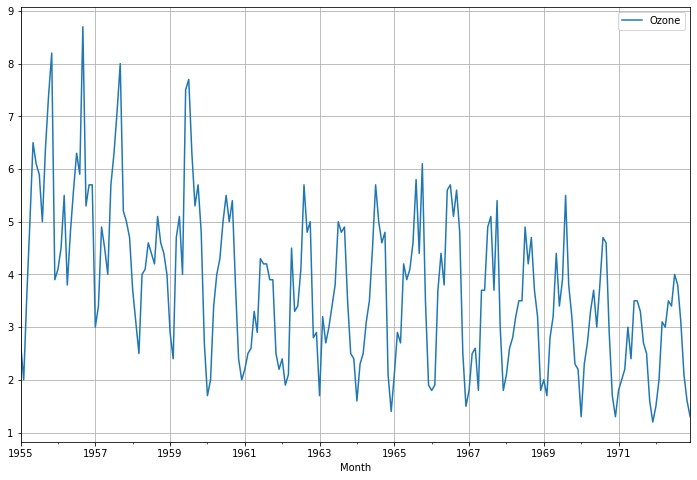

In [5]:
%matplotlib inline  
ozone_dataframe.plot.line('Month', ['Ozone'], grid = True, figsize=(12, 8))


Now, we can build/train a time series model with PyAF to forecast the next 12 values:


In [6]:
import pyaf.ForecastEngine as autof
lEngine = autof.cForecastEngine()
lEngine.train(ozone_dataframe , 'Month' , 'Ozone', 12);

INFO:pyaf.timing:('OPERATION_START', ('SIGNAL_TRAINING', {'Signals': ['Ozone'], 'Transformations': [('Ozone', 'None', '_', 'T+S+R'), ('Ozone', 'None', 'Diff_', 'T+S+R'), ('Ozone', 'None', 'RelDiff_', 'T+S+R'), ('Ozone', 'None', 'CumSum_', 'T+S+R')], 'Cores': 4}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'Ozone', 'Transformation': 'CumSum_Ozone'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'Ozone', 'Transformation': 'Diff_Ozone'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'Ozone', 'Transformation': 'RelDiff_Ozone'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'Ozone', 'Transformation': '_Ozone'}))
/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWa

In [7]:
lEngine.getModelInfo()

INFO:pyaf.std:TIME_DETAIL TimeVariable='Month' TimeMin=1955-01-01T00:00:00.000000 TimeMax=1968-07-01T00:00:00.000000 TimeDelta=<DateOffset: months=1> Horizon=12
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='Ozone' Length=216  Min=1.2 Max=8.7  Mean=3.7726851851851846 StdDev=1.4881769275050263
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_Ozone' Min=0.0 Max=1.0  Mean=0.3430246913580246 StdDev=0.19842359033400345
INFO:pyaf.std:DECOMPOSITION_TYPE 'T+S+R'
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_Ozone_LinearTrend_residue_zeroCycle[0.0]_residue_AR(54)' [LinearTrend + NoCycle + AR]
INFO:pyaf.std:TREND_DETAIL '_Ozone_LinearTrend' [LinearTrend]
INFO:pyaf.std:CYCLE_DETAIL '_Ozone_LinearTrend_residue_zeroCycle[0.0]' [NoCycle]
INFO:pyaf.std:AUTOREG_DETAIL '_Ozone_LinearTrend_residue_zeroCycle[0.0]_residue_AR(54)' [AR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1678 MAPE_Forecast=0.1588 MAPE_Test=0.1422
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.1

At this point, PyAF has tested all possible time series models and selected the best one. The whole process took about 7 seconds in this test.

to predict the next values using this model and show the last 20 values :


In [8]:
ozone_forecast_dataframe = lEngine.forecast(ozone_dataframe, 12);
ozone_forecast_dataframe.tail(20)

INFO:pyaf.timing:('OPERATION_START', ('FORECASTING', {'Signals': ['Ozone'], 'Horizon': 12}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.279, ('FORECASTING', {'Signals': ['Ozone'], 'Horizon': 12}))


,Month,Ozone,row_number,Month_Normalized,_Ozone,_Ozone_LinearTrend,_Ozone_LinearTrend_residue,_Ozone_LinearTrend_residue_zeroCycle[0.0],_Ozone_LinearTrend_residue_zeroCycle[0.0]_residue,_Ozone_LinearTrend_residue_zeroCycle[0.0]_residue_AR(54),...,Ozone_Residue,Ozone_Forecast_Lower_Bound,Ozone_Forecast_Upper_Bound,Ozone_Forecast_Quantile_2,Ozone_Forecast_Quantile_18,Ozone_Forecast_Quantile_34,Ozone_Forecast_Quantile_50,Ozone_Forecast_Quantile_66,Ozone_Forecast_Quantile_82,Ozone_Forecast_Quantile_98
208,1972-05-01,3.5,208,1.283976,0.306667,0.184525,0.122142,0.0,0.122142,0.078824,...,0.324881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
209,1972-06-01,3.4,209,1.290264,0.293333,0.182949,0.110385,0.0,0.110385,0.120118,...,-0.072995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,1972-07-01,4.0,210,1.296349,0.373333,0.181423,0.191911,0.0,0.191911,0.126510,...,0.490508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,1972-08-01,3.8,211,1.302637,0.346667,0.179846,0.166821,0.0,0.166821,0.124706,...,0.315858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,1972-09-01,3.1,212,1.308925,0.253333,0.178269,0.075064,0.0,0.075064,0.076797,...,-0.012997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,1972-10-01,2.1,213,1.315010,0.120000,0.176744,-0.056744,0.0,-0.056744,-0.033749,...,-0.172460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,1972-11-01,1.6,214,1.321298,0.053333,0.175167,-0.121834,0.0,-0.121834,-0.139083,...,0.129371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,1972-12-01,1.3,215,1.327383,0.013333,0.173641,-0.160308,0.0,-0.160308,-0.188989,...,0.215106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,1973-01-01,NaN,216,1.333671,NaN,0.172065,NaN,0.0,NaN,-0.181959,...,NaN,0.030756,2.220834,-0.044696,0.430005,0.705862,1.034607,1.241811,1.452416,1.962865
217,1973-02-01,NaN,217,1.339959,NaN,0.170488,NaN,0.0,NaN,-0.133212,...,NaN,0.358946,2.600191,0.404672,0.768051,0.985423,1.292540,1.515255,1.760579,2.209783


Here, we see that 
1. The last 12 values of the 'Month' column have been filled on a monthly basis for the next year (1973). 
2. The last 12 values of the 'Ozone' column are empty or unknown ('Nan').
3. A lot of extra columns have been computed



The most impostant new column is 'Ozone_Forecast', we can tsee the last rows of this column as well as the time and signal columns :

In [9]:
ozone_forecast_dataframe[['Month' , 'Ozone' , 'Ozone_Forecast']].tail(20)

,Month,Ozone,Ozone_Forecast
208,1972-05-01,3.5,3.175119
209,1972-06-01,3.4,3.472995
210,1972-07-01,4.0,3.509492
211,1972-08-01,3.8,3.484142
212,1972-09-01,3.1,3.112997
213,1972-10-01,2.1,2.272460
214,1972-11-01,1.6,1.470629
215,1972-12-01,1.3,1.084894
216,1973-01-01,NaN,1.125795
217,1973-02-01,NaN,1.479568


The predicted value for '1973-01-01' is then '0.811919' , etc

It is possible to plot the forecast against the signal toc check the 'visual' quality of the model and see the prediction intervals

<AxesSubplot:xlabel='Month'>

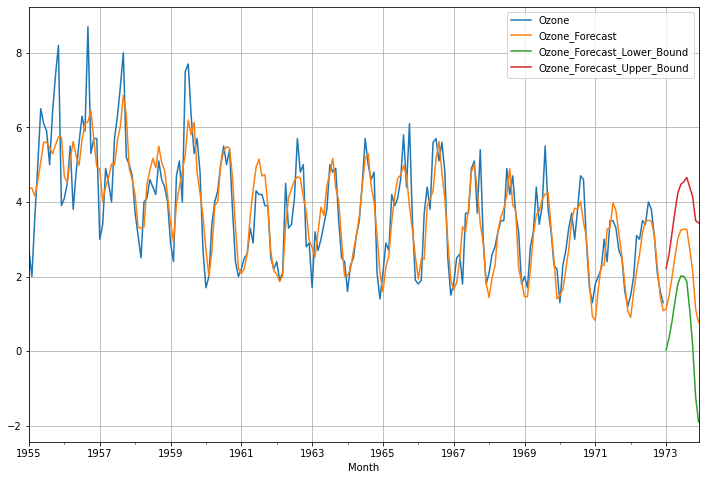

In [10]:
ozone_forecast_dataframe.plot.line('Month', ['Ozone' , 'Ozone_Forecast', 
                                             'Ozone_Forecast_Lower_Bound', 
                                             'Ozone_Forecast_Upper_Bound'], grid = True, figsize=(12, 8))

Finally, one can the save the forecasts datafrma eto a CSV file or a database :

In [11]:
ozone_forecast_dataframe.to_csv("ozone_forecast.csv")

### PyAF on some stock value

Using Yahoo Finance all public stock data are available. Here we give an exsample of how one can use PyAF to predict the future values of a popular stock (GOOG).

In [12]:
# yahoo finance is no longer available ....
#goog_link = "http://chart.finance.yahoo.com/table.csv?s=GOOG&a=8&b=14&c=2015&d=9&e=14&f=2016&g=d&ignore=.csv"
goog_link = 'https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/YahooFinance/nasdaq/yahoo_GOOG.csv'
    
import pandas as pd
goog_dataframe = pd.read_csv(goog_link);
goog_dataframe['Date'] = goog_dataframe['Date'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))
goog_dataframe.sort_values(by = 'Date' , ascending=True, inplace=True)
goog_dataframe.tail()

,Unnamed: 0,Symbol,Date,Close,Low,Volume,Open,Adj_Close,High
4,4,GOOG,2016-07-21,738.630005,735.830994,969100,740.359985,738.630005,741.690002
3,3,GOOG,2016-07-22,742.739990,736.559998,1256300,741.859985,742.739990,743.239990
2,2,GOOG,2016-07-25,739.770020,737.500000,1030700,740.669983,739.770020,742.609985
1,1,GOOG,2016-07-26,738.419983,734.270020,1179400,739.039978,738.419983,741.690002
0,0,GOOG,2016-07-27,741.770020,737.000000,1497100,738.280029,741.770020,744.460022


We needed to tranform the date column and sort values in increasing order (the yahoo API gives most recent values first).

We are interested in getting the future values of the 'Close' column over the next 7 days:

In [13]:
import pyaf.ForecastEngine as autof
lEngine = autof.cForecastEngine()
lEngine.train(goog_dataframe , 'Date' , 'Close', 7);

INFO:pyaf.timing:('OPERATION_START', ('SIGNAL_TRAINING', {'Signals': ['Close'], 'Transformations': [('Close', 'None', '_', 'T+S+R'), ('Close', 'None', 'Diff_', 'T+S+R'), ('Close', 'None', 'RelDiff_', 'T+S+R'), ('Close', 'None', 'CumSum_', 'T+S+R')], 'Cores': 4}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'Close', 'Transformation': '_Close'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'Close', 'Transformation': 'Diff_Close'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'Close', 'Transformation': 'CumSum_Close'}))
INFO:pyaf.timing:('OPERATION_START', ('TRAINING', {'Signal': 'Close', 'Transformation': 'RelDiff_Close'}))
/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/home/antoine/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWa

The predicted values are :

In [14]:
goog_forecast_dataframe = lEngine.forecast(goog_dataframe, 7);

INFO:pyaf.timing:('OPERATION_START', ('FORECASTING', {'Signals': ['Close'], 'Horizon': 7}))
INFO:pyaf.timing:('OPERATION_END_ELAPSED', 0.137, ('FORECASTING', {'Signals': ['Close'], 'Horizon': 7}))


We can see the forecasts data for last 7 days 

In [15]:
goog_forecast_dataframe[['Date' , 'Close' , 'Close_Forecast']].tail(7)

,Date,Close,Close_Forecast
1258,2016-07-28,NaN,741.77002
1259,2016-07-29,NaN,741.77002
1260,2016-07-30,NaN,741.77002
1261,2016-07-31,NaN,741.77002
1262,2016-08-01,NaN,741.77002
1263,2016-08-02,NaN,741.77002
1264,2016-08-03,NaN,741.77002


One can see that all the values are equal to the last value (naive model). Forecasting finance data is not easy!!!

If you are curious enough, you can see more info about the model :

In [16]:
lEngine.getModelInfo()

INFO:pyaf.std:TIME_DETAIL TimeVariable='Date' TimeMin=2011-07-28T00:00:00.000000 TimeMax=2015-07-20T00:00:00.000000 TimeDelta=<DateOffset: days=1> Horizon=7
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='Close' Length=1258  Min=490.920851 Max=1220.172036  Mean=696.2858158593018 StdDev=168.76391868223206
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_Close' Min=0.0 Max=1.0  Mean=0.28161073863637326 StdDev=0.231420835719632
INFO:pyaf.std:DECOMPOSITION_TYPE 'T+S+R'
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_Close_Lag1Trend_residue_bestCycle_byMAPE_residue_NoAR' [Lag1Trend + Cycle_None + NoAR]
INFO:pyaf.std:TREND_DETAIL '_Close_Lag1Trend' [Lag1Trend]
INFO:pyaf.std:CYCLE_DETAIL '_Close_Lag1Trend_residue_bestCycle_byMAPE' [Cycle_None]
INFO:pyaf.std:AUTOREG_DETAIL '_Close_Lag1Trend_residue_bestCycle_byMAPE_residue_NoAR' [NoAR]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.0114 MAPE_Forecast=0.0116 MAPE_Test=0.0042
INFO:pyaf.std:MODEL_SMAPE SMA

Again, one can plot the forecasts against the signal:

<AxesSubplot:xlabel='Date'>

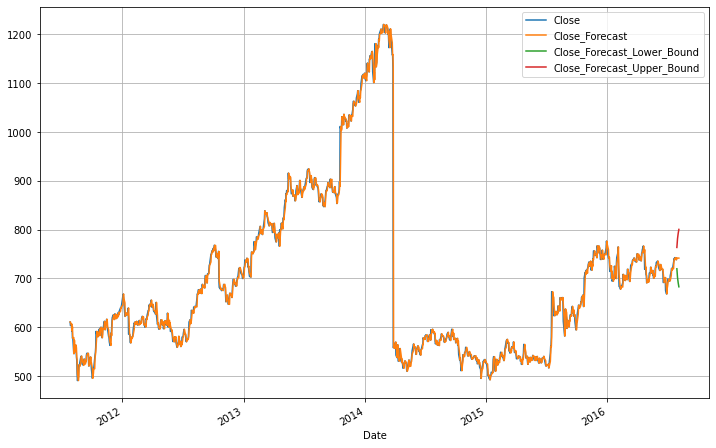

In [17]:
goog_forecast_dataframe.plot.line('Date', ['Close' , 'Close_Forecast', 
                                             'Close_Forecast_Lower_Bound', 
                                             'Close_Forecast_Upper_Bound'], grid = True, figsize=(12, 8))